# NBA Sleepers

## By: Carlos Villagomez & Kevin Tran

## CPSC 310, Spring 2019

## Introduction

We are using a dataset consisting of two decades worth of NBA player data ranging from the 1996-2016 seasons on each player's seasonal statistics who was a member of a team's roster. We implemented several classification models including K-Nearest Neighbor (KNN), Sklearn KNN, Naive Bayes, Sklearn Naive Bayes, Linear Regression, and Sklearn Linear Regression to classify whether a player is a "sleeper" or not. We define a "sleeper" pick as a player whose net rating, which is a stat that evaluates a team's point differential per 100 possessions while he is on the court is greater than or equal to the average player of the next highest draft stock. For example, someone like Zach Randolph, who is predicted to be selected in the Top 5, but was actually selected in the late 1st round would be classified as a "sleeper". We found that the most accurate classification approach was KNN when predicting the "sleeper" picks.

## Data Analysis

The dataset consists of 21 attribute values including each player's demographic variables (e.g. height, weight, age, etc.), biographical details (team, draft year, round, etc.), and basic box score statistics (avg points, rebounds, assists, etc.). There are 9,561 total instances of players, but only 1,892 unique players in the dataset. Now, there were initially 51 rows of missing data, but the author of the dataset handled this by manually filling the gaps using player data from the online database, Basketball Reference.

The data of the players were organized by averaging all their career stats and running a sleeper definer algorithm on them. The first figure shows the average net rating difference between the draft stocks, and that was used help to determine what is a proper "sleeper". The second figure shows the frequency of players in the laegue and where they were drafted. The number 0 indicates the players who played that were undrafted. The majority of the league is undrafted players. The third figure shows the differencee between a use percentage of a player and their net rank. There is correlation between a high net rating and high usage percentage; however, most players in the league are just average.

########################
Stat Summary of the Data
########################
Total Unqiue Players Analyzed:  1892
Average  gp :  268.20084566596194
Average  pts :  5.901963407943847
Average  ast :  1.3103850361277742
Average  reb :  2.7334402285872867
Average  net_rating :  -4.777268267068417
Average  usg_pct :  0.18219910543015408
Average  ts_pct :  0.47887587898399353
Average  ast_pct :  0.12128922972331578


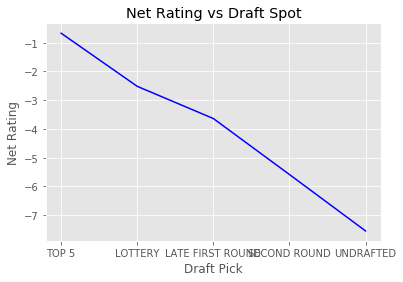

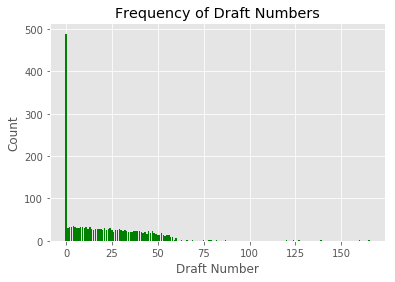

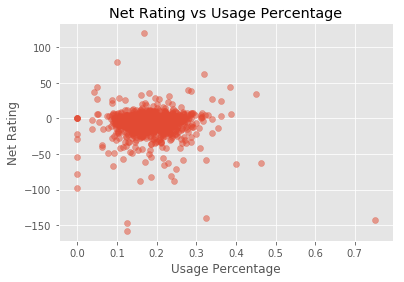

In [11]:
import csv
import matplotlib.pyplot as plot
import random
import numpy as np
import math
from collections import Counter
import operator
from csv import DictWriter, DictReader
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
import matplotlib.pyplot as plt 
import matplotlib
import numpy as np
from matplotlib.colors import ListedColormap
from sklearn.metrics import classification_report

matplotlib.style.use('ggplot') 

headers = ['player_name', 'college', 'draft_year', 'draft_round', 'draft_number',
           'gp', 'pts', 'reb', 'ast', 'net_rating', 'usg_pct', 'ts_pct', 'ast_pct']
linearRegressor = LinearRegression()


class Player:
    def __init__(self, data):
        self.player_name = data['player_name']
        self.college = data['college']
        self.draft_year = data['draft_year']
        self.draft_round = data['draft_round']
        self.draft_number = data['draft_number']
        self.gp = [float(data['gp'])]
        self.pts = [float(data['pts'])]
        self.reb = [float(data['reb'])]
        self.ast = [float(data['ast'])]
        self.net_rating = [float(data['net_rating'])]
        self.usg_pct = [float(data['usg_pct'])]
        self.ts_pct = [float(data['ts_pct'])]
        self.ast_pct = [float(data['ast_pct'])]
        self.sleeper = 0


def draft_converter(num):
    if num > 0 and num <= 5:
        return "TOP 5"
    elif num >= 6 and num <= 14:
        return "LOTTERY"
    elif num >= 15 and num <= 30:
        return "LATE FIRST ROUND"
    elif num >= 31:
        return "SECOND ROUND"
    else:
        return "UNDRAFTED"


def org_players(file, headers):
    with open(file) as read:
        csv_reader = csv.DictReader(read)
        players = {}
        for row in csv_reader:
            if row['player_name'] not in players:
                data = {}
                for i in headers:
                    data[i] = row[i]
                players[row['player_name']] = (Player(data))
            else:
                for i in headers[5:len(headers)]:
                    getattr(players[row['player_name']],
                            i).append(float(row[i]))

        for k, v in players.items():
            generate_career_avgs(v)
        return players


def generate_career_avgs(player):
    player.gp = sum(player.gp)
    player.pts = sum(player.pts) / len(player.pts)
    player.reb = sum(player.reb) / len(player.reb)
    player.ast = sum(player.ast) / len(player.ast)
    player.net_rating = sum(player.net_rating) / len(player.net_rating)
    player.usg_pct = sum(player.usg_pct) / len(player.usg_pct)
    player.ts_pct = sum(player.ts_pct) / len(player.ts_pct)
    player.ast_pct = sum(player.ast_pct) / len(player.ast_pct)
    if player.draft_number == "Undrafted":  # set all undrafted to 0
        player.draft_year = 0.0
        player.draft_round = 0.0
        player.draft_number = 0.0


def sort_to_table(players):
    table = []
    for k, v in players.items():
        table.append([v.player_name, v.gp, v.pts, v.reb,
                      v.ast, v.net_rating, v.usg_pct, v.ts_pct, v.ast_pct, int(v.draft_number), v.sleeper])
    return table

def sleeper_definer(players):
    avgs = {"TOP 5": [],  "LOTTERY": [],
            "LATE FIRST ROUND": [], "SECOND ROUND": [], "UNDRAFTED": []}

    for k, v in players.items():

        player_draft = draft_converter(int(v.draft_number))
        avgs[player_draft].append(v.net_rating)

    for k, v in avgs.items():
        avgs[k] = sum(v)/len(v)

    for k, v in players.items():
        player_draft = draft_converter(int(v.draft_number))

        if player_draft == "UNDRAFTED" and v.net_rating > avgs["LATE FIRST ROUND"]:
            players[k].sleeper = 1
        elif player_draft == "SECOND ROUND" and v.net_rating > avgs["LATE FIRST ROUND"]:
            players[k].sleeper = 1
        elif player_draft == "LATE FIRST ROUND" and v.net_rating > avgs["LOTTERY"]:
            players[k].sleeper = 1
        elif player_draft == "LOTTERY" and v.net_rating > avgs["TOP 5"]:
            players[k].sleeper = 1
def data_analysis(players, table):
    # ########################################################
    # Summary Statistics
    # ########################################################
    avg_data = {'gp': 0, 'pts': 0, 'ast':0, 'reb':0, 'net_rating': 0, 'usg_pct': 0, 'ts_pct': 0, 'ast_pct':0}

    for k, v in players.items():
        avg_data['gp'] += v.gp
        avg_data['pts'] += v.pts
        avg_data['ast'] += v.ast
        avg_data['reb'] += v.reb
        avg_data['net_rating'] += v.net_rating
        avg_data['usg_pct'] += v.usg_pct
        avg_data['ts_pct'] += v.ts_pct
        avg_data['ast_pct'] += v.ast_pct

    
    for key, value in avg_data.items():
        avg_data[key] = value/len(players)
    print("########################")
    print("Stat Summary of the Data")
    print("########################")
    print("Total Unqiue Players Analyzed: ", len(players))
    for key, value in avg_data.items():
        print("Average ", key,": ", value)
        
    # ########################################################
    # Net Rating vs Draft pick defining how we do our sleepers
    # ########################################################
    avgs = {"TOP 5": [],  "LOTTERY": [],
            "LATE FIRST ROUND": [], "SECOND ROUND": [], "UNDRAFTED": []}

    for k, v in players.items():

        player_draft = draft_converter(int(v.draft_number))
        avgs[player_draft].append(v.net_rating)

    for k, v in avgs.items():
        avgs[k] = sum(v)/len(v)
    
    y = [ v for k, v in avgs.items()]
    x = [ k for k, v in avgs.items()]

    plot.plot(x, y, color='blue')
    plot.title('Net Rating vs Draft Spot')
    plot.xlabel('Draft Pick')
    plot.ylabel('Net Rating')
    plot.show()



    # ########################################################
    # AMOUNT OF PEOPLE IN DRAFT AT THE NUMBER OF IT 
    # ########################################################
    freq = {}
    for p in table:
        if p[9] in freq:
            freq[p[9]] += 1
        else:
            freq[p[9]] = 1

    y = np.array([v for k,v in freq.items()])
    x = np.array([k for k,v in freq.items()])


    plt.bar(x, y, color='green')
    plt.xlabel("Draft Number")
    plt.ylabel("Count")
    plt.title("Frequency of Draft Numbers")
    plt.show()

    # ########################################################
    # Which value was more important in usuage vs net rating
    # ########################################################


    y = [p[6] for p in table]
    x = [p[5] for p in table]

    plt.scatter(y, x, alpha=0.5)
    plt.ylabel("Net Rating")
    plt.xlabel("Usage Percentage")
    plt.title("Net Rating vs Usage Percentage")
    plt.show()

players = org_players('all_seasons.csv', headers)
sleeper_definer(players)
table = sort_to_table(players)
data_analysis(players, table)


## Classification Results

We decided on 3 classification approaches: linear regression, k nearest neighbor, and naivee bayes. For ensemble learning, we randomized the amouonts of k in our knn model. Along with our own implementation of the 3 models, wee also compare them to sklearn's implementation. 

### Linear Regression

For linear regression, the x value was the net rating and the y value is 0 or 1. 1 represents a sleeper and 0 represents non-sleeper. When returning values, the predicted is rounded to either 0 or 1 to help classifictation if prediction was over or under .5. 

In [12]:
def calc_slope(X, Y, mean_x, mean_y):
    numer = 0
    denom = 0
    m = len(X)
    for i in range(m):
        numer += (X[i] - mean_x) * (Y[i] - mean_y)
        denom += (X[i] - mean_x) ** 2
    slope = numer / denom
    return slope

def results_linear_reg(slope, b, x):
    guess = (slope*x) + b
    return guess

def linear_reg(x_values, y_values):
    ym = np.mean(y_values)
    xm = np.mean(x_values)
    slope = calc_slope(x_values, y_values, xm, ym)
    b = ym - (xm*slope)
    return slope, b

def get_column(table, index):
    col = []
    for row in table:
        col.append(float(row[index]))
    return col

def useful_rows(table, idxs):
    t = []
    for row in table:
        temp = []
        for i in idxs:
            temp.append(row[i])

        t.append(temp)
    return t

def linear(table):
    print("LINEAR (NOT SKLEARN)")
    y_values = get_column(table, 10)
    x_values = useful_rows(table, [0, 5])

    xT, xTs, yTrain, yTest = train_test_split(
        x_values, y_values, test_size=1/3, random_state=0)

    xTest_names = useful_rows(xTs, [0])
    xTrain = useful_rows(xT, [1])
    xTest = useful_rows(xTs, [1])

    slope, b = linear_reg(xTrain, yTrain)
    test_linear(slope, b, xTest, yTest, xTest_names)
    
def test_linear(slope, b, test_x, test_y, names):
    acc = 0
    sleepers = []
    for idx, row in enumerate(test_x):
        guess = results_linear_reg(slope, b, row)
        if guess >= .5:
            guess = 1
        else:
            guess = 0
        if guess == test_y[idx]:
            acc += 1
        if guess == 1 and test_y[idx] == 1:
            sleepers.append(names[idx])
    
    print("Accuracy: ", (acc/len(test_y)))


linear(table)

    


LINEAR (NOT SKLEARN)
Accuracy:  0.7765451664025357


### Sklearn Linear Regression
When using the Sklearn library for linear regression, we compared the same attributes on the x and y-axes as in our own model defined above in which the x-value represents the net rating and the y-value as 0 oeither a sleeper or non-sleeper where 1 = sleeper and 0 = non-sleeper. Once again, the predicted value for determining whether a player is a sleeper was rounded either to 0 or 1 if the prediction was over or under 0.5.

In [9]:
def sklearn_linear(table):
    y_values = get_column(table, 10)
    x_values = useful_rows(table, [0, 5])

    xT, xTs, yTrain, yTest = train_test_split(
        x_values, y_values, test_size=1/3, random_state=0)

    xTest_names = useful_rows(xTs, [0])
    xTrain = useful_rows(xT, [1])
    xTest = useful_rows(xTs, [1])
    xTrain = np.array(xTrain)
    yTrain = np.array(yTrain)
    xTrain = xTrain.reshape(-1, 1)
    yTrain = yTrain.reshape(-1, 1)

    xTest = np.array(xTest)
    yTest = np.array(yTest)
    xTest = xTest.reshape(-1, 1)
    yTest = yTest.reshape(-1, 1)

    linearRegressor.fit(xTrain, yTrain)
    yPrediction = linearRegressor.predict(xTest)
    yPrediction = [1 if i >= .5 else 0 for i in yPrediction]
    print("Accuracy Score:", metrics.accuracy_score(yTest, yPrediction))

sklearn_linear(table)

Accuracy Score: 0.7765451664025357


### Sklearn Linear Regression vs Linear Regression Evaluation

Both sklearn and our linear regreession return the exact same accuracy. At roughly 77.7% accuuracy with the same data. This means our method of solving linear regression is the same as sklearns. Overall, this model yieled great accuracy for predicting sleepers based on net rating. 

### KNN

For performing KNN, we first had to determine how many clusters yields the best classification accuracy. Through trial and error, we discovered that k = 13 results in the highest classification value of 0.707. Based on our results, it is clear that a classification of 0.0 = "non-sleeper" is more precise than a classification of 1.0 = "sleeper" since 0.72 > 0.68. It also has a higher recall value or "completeness" than non-sleeper players, F1 score, and support which all indicate the classification results for non-sleepers are more useful than sleeper picks.


In [16]:
def normalize(xs, x):
    return (x - min(xs)) / ((max(xs) - min(xs)) * 1.0)


def knn(train_x, test_x, k):
    x = getNeighbors(train_x, len(train_x[0]), test_x, k)
    return x


def compute_distance(v1, v2, length):
    distance = 0
    for x in range(length):
        distance += pow((v1[x] - v2[x]), 2)
    return math.sqrt(distance)


def getNeighbors(training_set, n, instance, k):
    row_distances = []
    for row in training_set:
        d = compute_distance(row, instance, n - 1)
        row_distances.append([d, row])
    row_distances.sort(key=operator.itemgetter(0))
    neighbors = []
    for x in range(k):
        neighbors.append(row_distances[x][1])

    lst = []
    for ind, x in enumerate(neighbors):
        lst.append(neighbors[ind][-1])
    data = Counter(lst)
    return data.most_common(1)[0][0]

def knn_ex(table):
    print("KNN (NOT SKLEARN)")
    knn_sleepers = []
    y_knn = get_column(table, 10)
    x_knn = useful_rows(table, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
    xT, xTs, yTrain, yTest = train_test_split(
        x_knn, y_knn, test_size=1/3, random_state=0)

    knn_test_names = useful_rows(xTs, [0])
    # Normalize our X
    for idx, row in enumerate(xT):
        for ind, i in enumerate(row[1:-1]):
            xs = get_column(xT, ind+1)
            xT[idx][ind+1] = normalize(xs, i)
    for idx, row in enumerate(xTs):
        for ind, i in enumerate(row[1:-1]):
            xs = get_column(xTs, ind+1)
            xTs[idx][ind+1] = normalize(xs, i)

    xT = useful_rows(xT, [1,2,3,4,5,6,7,8,9,10])
    knn_acc = 0
    y_pred = []
    for idx, row in enumerate(xTs):
        pred = knn(xT, row[1:], 13)
        y_pred.append(pred)
        if pred == row[-1]:
            knn_acc += 1
            if pred == 1 and row[-1] == 1:
                knn_sleepers.append(knn_test_names[idx])

    print("KNN Accuracy: ", knn_acc/len(xTs))
    print(classification_report(yTest, y_pred))

    
knn_ex(table)

KNN (NOT SKLEARN)
KNN Accuracy:  0.7068145800316957
              precision    recall  f1-score   support

         0.0       0.72      0.82      0.77       370
         1.0       0.68      0.54      0.60       261

   micro avg       0.71      0.71      0.71       631
   macro avg       0.70      0.68      0.69       631
weighted avg       0.70      0.71      0.70       631



### Sklearn knn

For performing KNN using the Sklearn library, we already determined that k = 13 clusters yields the best classification accuracy of 0.707. Also, if you look at the graph below, one can see that the accuracy for classification increases as the value of "k" clusters increases until it peaks at a value of k = 13 clusters and then it begins to drop at k = 14 clusters. This value is identical to our own model for KNN which means we did a good job of replicating the KNN model obtained from the Sklearn library. Just as our own KNN model, it is clear that a classification of 0.0 = "non-sleeper" is more precise than a classification of 1.0 = "sleeper" since 0.72 > 0.68. It also has a higher recall value or "completeness" than non-sleeper players, F1 score, and support which all indicate the classification results for non-sleepers are more useful than sleeper picks.

KNN ACCRUACY k=13:  0.7068145800316957
              precision    recall  f1-score   support

         0.0       0.72      0.82      0.77       370
         1.0       0.68      0.54      0.60       261

   micro avg       0.71      0.71      0.71       631
   macro avg       0.70      0.68      0.69       631
weighted avg       0.70      0.71      0.70       631



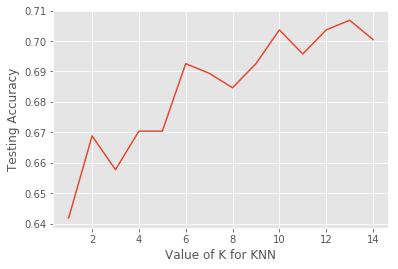

In [15]:
def sklearn_knn(table):
    y_knn = get_column(table, 10)
    x_knn = useful_rows(table, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    xT, xTs, yTrain, yTest = train_test_split(
        x_knn, y_knn, test_size=1/3, random_state=0)

    knn_test_names = useful_rows(xTs, [0])
    xT = useful_rows(xT, [1,2,3,4,5,6,7,8,9])
    xTs = useful_rows(xTs, [1,2,3,4,5,6,7,8,9])

    for idx, row in enumerate(xT):
        for ind, i in enumerate(row):
            xs = get_column(xT, ind)
            xT[idx][ind] = normalize(xs, i)
    for idx, row in enumerate(xTs):
        for ind, i in enumerate(row):
            xs = get_column(xTs, ind)
            xTs[idx][ind] = normalize(xs, i)

    knn = KNeighborsClassifier(n_neighbors=13)
    knn.fit(xT, yTrain)
    y_pred = knn.predict(xTs)
    print("KNN ACCRUACY k=13: ", metrics.accuracy_score(yTest, y_pred))
    print(classification_report(yTest, y_pred))

    scores = []

    for k in range(1,15):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(xT, yTrain)
        y_pred = knn.predict(xTs)
        scores.append(metrics.accuracy_score(yTest, y_pred))

    plt.plot(range(1,15), scores)
    plt.xlabel('Value of K for KNN')
    plt.ylabel('Testing Accuracy')
    plt.show()
    
sklearn_knn(table)

### Sklearn KNN vs KNN evaluation

When comparing Sklearn's KNN classification model with our own model, our results are equivalent in all respects when classifying players as either "sleepers" or "non-sleepers". This indicates that we did a excellent job of recreating Sklearn's KNN classification model such that we were able to replicate not only equal accuracy, but also precision, recall, F1 score, support, and average values as well.

### Naive Bayes

Now when evaluating our Naive Bayes classifier, it resulted in an accuracy of 0.651 when predicting players as either "sleepers" or "non-sleepers". Once again, the "non-sleeper" classification had a much higher precision value of 0.89 as opposed to "sleeper" picks who are only predicted to have a precision of 0.55. Thus, the difference between the two is more drastic as opposed to our KNN model. On the other hand, the recall value of sleepers is much higher than non-sleepers at 0.92 vs. 0.46 where "sleepers" have a much higher completeness than "non-sleepers. Next, sleepers also have a higher F1 score than non-sleepers at 0.69 vs. 0.61 which indicates a greater harmonic mean of precision and recall. Yet, non-sleepers have a much higher support value at 370 rather than sleepers who only had a support value of 261 in which clearly a higher proportion of the data set was correctly by the rule for non-sleepers, which yields the much higher precision value for non-sleeper picks.

In [22]:
def gaussian(x, mean, sdev):
    first, second = 0, 0
    if sdev > 0:
        first = 1 / (math.sqrt(2 * math.pi) * sdev)
        second = math.e ** (-((x - mean) ** 2) / (2 * (sdev ** 2)))
    return first * second


def sep_class(table):
    label = {}
    for idx, row in enumerate(table):
        if row[-1] not in label:
            label[row[-1]] = []
        label[row[-1]].append(row)
    return label


def mean(numbers):
    return sum(numbers)/float(len(numbers))


def stdev(numbers):
    avg = mean(numbers)
    variance = sum([pow(x-avg, 2) for x in numbers])/float(len(numbers)-1)
    return math.sqrt(variance)


def summarize(dataset):
    summaries = [(np.mean(attribute), np.std(attribute))
                 for attribute in zip(*dataset)]
    del summaries[-1]
    return summaries


def summarizeByClass(dataset):
    separated = sep_class(dataset)
    summaries = {}
    for classValue, instances in separated.items():
        summaries[classValue] = summarize(instances)
    return summaries    

def predict(summaries, inputVector):
    probabilities = calculateClassProbabilities(summaries, inputVector)
    bestLabel, bestProb = None, -1
    for classValue, probability in probabilities.items():
        if bestLabel is None or probability > bestProb:
            bestProb = probability
            bestLabel = classValue
    return bestLabel


def calculateClassProbabilities(summaries, inputVector):
    probabilities = {}
    for classValue, classSummaries in summaries.items():
        probabilities[classValue] = 1
        for i in range(len(classSummaries)):
            mean, stdev = classSummaries[i]
            x = inputVector[i]
            probabilities[classValue] *= gaussian(x, mean, stdev)
    return probabilities

def naive_bayes(table):
    naive_sleepers = []
    print("NAIVE BAYES (NOT SKLEARN)")
    y_naive = get_column(table, 10)
    x_naive = useful_rows(table, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
    xT, xTs, yTrain, yTest = train_test_split(
        x_naive, y_naive, test_size=1/3, random_state=0)

    naive_test_names = useful_rows(xTs, [0])
    xT = useful_rows(xT, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
    xTs = useful_rows(xTs, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

    summary = summarizeByClass(xT)
    naive_acc = 0
    y_pred = []
    for idx, row in enumerate(xTs):
        p = predict(summary, row)
        y_pred.append(p)
        if p == row[-1]:
            naive_acc += 1
            if p == 1 and row[-1] == 1:
                naive_sleepers.append(naive_test_names[idx])
    print("Accuracy: ", naive_acc/len(xTs))
    print(classification_report(yTest, y_pred))

naive_bayes(table)

NAIVE BAYES (NOT SKLEARN)
Accuracy:  0.6513470681458003
              precision    recall  f1-score   support

         0.0       0.89      0.46      0.61       370
         1.0       0.55      0.92      0.69       261

   micro avg       0.65      0.65      0.65       631
   macro avg       0.72      0.69      0.65       631
weighted avg       0.75      0.65      0.64       631



### Sklearn Naive Bayes

Next, we will take a look at the Sklearn Naive Bayes classifier, it resulted in an accuracy of 0.704 when predicting players as either "sleepers" or "non-sleepers". Just as in our own model, the "non-sleeper" classification had a much higher precision value of 0.86 as opposed to "sleeper" picks who only had a precision value of 0.60. In addition, the recall value of sleepers is much higher than non-sleepers at 0.86 vs. 0.59 where "sleepers" once again have a much higher completeness than "non-sleepers. Next, sleepers barely have a higher F1 score than non-sleepers at 0.71 vs. 0.70 which indicates a greater harmonic mean of precision and recall, but nonetheless they are nearly identical values. Once again, non-sleepers had a much higher support value at 370 rather than sleepers who only had a support value of 261 in which just as our own model, a higher proportion of the data set was correctly predicted by the rule for non-sleepers, thus yielding a much higher precision value for non-sleeper picks.

In [23]:
def sklearn_naive(table):
    print("SKLEARN NAIVE BAYES")
    gnb = GaussianNB()

    y_naive = get_column(table, 10)
    x_naive = useful_rows(table, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
    xT, xTs, yTrain, yTest = train_test_split(
        x_naive, y_naive, test_size=1/3, random_state=0)
    y_test_names = useful_rows(xTs, [0])
    xT = useful_rows(xT, [1,2,3,4,5,6,7,8,9])
    xTs = useful_rows(xTs, [1,2,3,4,5,6,7,8,9])
    gnb.fit(xT, yTrain)
    y_pred = gnb.predict(xTs)
    score = metrics.accuracy_score(yTest, y_pred)
    print("SKLEARN NAIVE ACCURACY: ", score)
    print(classification_report(yTest, y_pred))

sklearn_naive(table)

SKLEARN NAIVE BAYES
SKLEARN NAIVE ACCURACY:  0.7036450079239303
              precision    recall  f1-score   support

         0.0       0.86      0.59      0.70       370
         1.0       0.60      0.86      0.71       261

   micro avg       0.70      0.70      0.70       631
   macro avg       0.73      0.73      0.70       631
weighted avg       0.75      0.70      0.70       631



### Sklearn Naive Bayes vs Naive Bayes Evaluation

When comparing Sklearn's Naive Bayes classification model with our own model, Sklearn's model had a higher accuracy at 0.704 where as our model only had an accuracy of 0.651. Although the values are very similar, the  higher accuracy of the Sklearn model is most likely as a result of the higher weighted averages for the recall and F1 scores. For instance, the higher weighted average recall score of the Sklearn Naive Bayes model of 0.70 as opposed to a value of 0.65 for our own model indicates that the Sklearn model has a much higher level of completeness. In addition, th higher weighted average of the F1 score for the Sklearn model also indicates the greater harmonic mean of precision and recall. Therefore, this indicates why the Sklearn has a accuracy when prediciting whether a player is a "sleeper" or "non-sleeper".

### Ensemble

For ensemble learning method, we wanted to test to see if majority voting on random and different knn attributes would give a beter resuts diluting more skewed neighbors.


In [24]:
def ensemble(table):
    print("EMSEMBLE KNN DIFFERENT ATTRIBUTES SELECTED")
    knn_sleepers = []
    y_knn = get_column(table, 10)
    x_knn = useful_rows(table, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
    xT, xTs, yTrain, yTest = train_test_split(
        x_knn, y_knn, test_size=1/3, random_state=0)

    knn_test_names = useful_rows(xTs, [0])
    # Normalize our X
    for idx, row in enumerate(xT):
        for ind, i in enumerate(row[1:-1]):
            xs = get_column(xT, ind+1)
            xT[idx][ind+1] = normalize(xs, i)
    for idx, row in enumerate(xTs):
        for ind, i in enumerate(row[1:-1]):
            xs = get_column(xTs, ind+1)
            xTs[idx][ind+1] = normalize(xs, i)

    trainings = {}
    # generate random sample of atttributes to use in the data list
    for i in range(5):
        ran = random.sample(range(1, 10), random.randint(1, 9))
        ran.sort()
        ran.append(10)
        trainings[i] = useful_rows(xT, ran)

    knn_acc = 0
    for idx, row in enumerate(xTs):

        majority = {0: 0, 1: 0}

        for k, v in trainings.items():
            pred = knn(v, row[1:], 10)
            majority[pred] += 1
        voted = max(majority.items(), key=operator.itemgetter(1))[0]

        if voted == row[-1]:
            knn_acc += 1
            if voted == 1 and row[-1] == 1:
                knn_sleepers.append(knn_test_names[idx])

    print("Ensemble KNN Accuracy: ", knn_acc/len(xTs))

ensemble(table)

EMSEMBLE KNN DIFFERENT ATTRIBUTES SELECTED
Ensemble KNN Accuracy:  0.6228209191759112


### Ensemble Evaluation 

With an accuracy that is less than a knn model without majority voting mixing it did not yield the intended results. It seems that this datta set is very sensitive when it comes to what attributes are selected and what k value is used. This is because the game of basketball is very dynamic and it is difficult to label whether a player can be a sleeper or not basede on a certain combinations of attributes. If one is a strong defensive player, their stats might be as aeesethically pleasing as an scorer, thus throwing the dataset off. 




## Conclusion

The dataset we used presented a few problems with analysis including  that the 51 rows that were initially missing data, but were handled by the author filled in the missing data from Basketball Reference. Also, because the statistics were only retrieved from the years 1996-2016, our results sometimes did not encompass the entirety of their careers. For instance, a player such as Joe Dumars, who is a hall-of-famer but retired in 1999 and thus our dataset only has data from 1996-1999 that does not encompass his best seasons in the NBA with the Detroit Pistons is only predicted as a lottery pick when he should really be labeled as a top 5 pick if you look at the entirety of his career when he was at his best during the late 1980's and early 1990's. The same goes for players who were drafted towards the end of our range and have only played a few years in the NBA before reaching the prime of their careers. An example of this would be Nikola Jokic who is now just playing the best basketball of his career after have just received his first All-Star selection in 2019 after being drafted in 2014 NBA draft as the 41st pick. However, his stats have significantly improved since his rooke season in 2015-2016 so while he is only predicted to be a lottery pick with our algorithm given the dataset we have, if we were to apply our algorithm containing statistics all the way up to the 2019 season he would likely be predicted to be a Top 5 rather than a lottery pick now that he is considered to be one of the best centers in the NBA.

We devloped a classification approach to determine whether a player is a "sleeper" based on whether their net rating is greater than or equal to  the average player of the next highest draft stock as described in the Introduction. Our linear regression classification model had a predictive accuracy of 0.786. Next, the Sklearn linear classification model had a predictive accuracy of 0.786. Our KNN classification model had a predictive accuracy of 0.621 with k = 13 clusters. Then our Naive Bayes model had a predictive accuracy of 0.678. While, the Sklean Naive Bayes classification had an accuracy of 0.697. Finally, our Ensemble KNN model had a predictive accuracy of 0.609. 